In [1]:
import math
import numpy as np
import pandas as pd
import sys
import re
from functions import *
from mining_functions import *
from collections import Counter
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy import stats
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        path = '/Documents/code/Phet-log-analyzer/cck/raw_data_parsing_check/'
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        if os.getenv("COMPUTERNAME") == 'PYRRHA':
                path = '/Documents/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
        else:
            path = '/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
        
df = pd.read_csv(get_path() + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
df["student"] = df["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()
df["Family_tool"]=df["Family_tool"].str.capitalize()
df["Family_default"]=df["Family_default"].str.capitalize()
df["Family_both"]=df["Family_both"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')


#### Crop activity data to get rid of activity #3

In [3]:
max_time = 25*60*1000
max_times = {s:min(df[df['student']==s]["Time Stamp"])+max_time for s in set(df['student'])}

def keep_by_time (row):
    if row["Time Stamp"] <= max_times[row["student"]]:
        return True
    else: 
        return False

df['keep'] = df.apply (lambda row: keep_by_time (row),axis=1)
df=df[df['keep']]

In [9]:
def add_text(attribute,family_category,cut_off, shortest_seq_length, longest_seq_length,B):
    text = """Showing sequences for students split by {0}, using the categories {1}.
            Removed sequences used by less than {2}% of students.
            Found sequences of lenght {3} to {4}.
            Using {5} time bins""".format(attribute,family_category,int(cut_off*100), shortest_seq_length, longest_seq_length,B)
    fig = plt.figure(figsize=(10, 4))
    ax = plt.gca()
    ax.text(0.5,0.5,text,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize = 15)
    plt.axis('off')
    return fig

def rank_sequences(sequence_counts,B,axesnum=None):
    ranks = []
    for seq,counts in sequence_counts.iteritems():
#         if np.sum(counts)>0:
        ranks.append((seq,calc_infogain(counts,B,axesnum)))
    return sorted(ranks, key=lambda tup: tup[1])

def get_top_seqs(ranks,N):
    return ranks[-N:]

STEPS
- get sequences (the same way we always do)
- remove all actions except C,P,$T_O$
- repeat analysis by group and time for seqs of lenths 2-10 (like last time)
- keep filter of 35% though prehaps we can increase it

OR, test frequency of all these seqs (6 combos):

* $T_1,T_2,T_M$ increasing complexity
* $T_1,T_M,T_2$ skipping compare and contrast
* $T_2,T_M,T_1$ back to basics
* $T_2,T_1,T_M$ back to basics then complex
* $T_M,T_1,T_2$ complex, then increasing
* $T_M,T_2,T_1$ decreasing in complextiy





### We are only interested in testing actions so we remove the rest
For now we don't do anything ig Test other and leave them there.

In [10]:
def keep_tests(k,seq):
    seq = [c for c in seq if c not in ['C','P']]
    return seq
blocks, timecoords = get_blocks_withTime_new(df, get_students('split pre','low'), 'Family', as_list = True, ignore = ['I'], start = False)
newblocks = {k:keep_tests(k,v) for k,v in blocks.iteritems()}

### Next we run the info gain analysis

In [25]:
students = get_students(attribute='split pre',level='low')
CUT_OFF = 0.35 #we keep only sequences used once by at least 10% of students
shortest_seq_length = 2
longest_seq_length = 10

### PARAMETERS
attributes = [('split post t2','high','low')]
family_categories = ["Family"]#,"Family_tool","Family_default"]

BINS = 1
sequence_counts = get_sequence_use_by_timebin(df,students,family_category,
                                          1,attribute,level1,level2,
                                          shortest_seq_length,longest_seq_length,CUT_OFF,remove_actions= ['C','P'])
tops = get_top_seqs(rank_sequences(sequence_counts,B,axis),15)

BINS = 4
sequence_counts = get_sequence_use_by_timebin(df,students,family_category,
                                  BINS,attribute,level1,level2,
                                  shortest_seq_length,longest_seq_length,CUT_OFF,remove_actions= ['C','P'])


Getting sequence use over 1 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.
Getting sequence use over 4 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.


## Let's take a closer look at the top sequences

In [26]:
tops

[('TsTcTcTc', 0.0059697885230435288),
 ('TcTcTb', 0.0059697885230435288),
 ('TbTbTbTs', 0.0059697885230435288),
 ('TbTbTs', 0.0067661802602934085),
 ('TsTcTc', 0.0080075965461443577),
 ('TbTb', 0.0080075965461443577),
 ('TbTbTb', 0.010412478777944267),
 ('TbTsTs', 0.010412478777944267),
 ('TsTc', 0.0123074911041966),
 ('TbTc', 0.020131243348847194),
 ('TcTcTcTcTcTcTc', 0.024880935059134024),
 ('TbTs', 0.026331935450379929),
 ('TcTcTcTcTcTcTcTc', 0.045565997075034947),
 ('TcTcTcTcTcTcTcTcTc', 0.067888432383325314),
 ('TcTcTcTcTcTcTcTcTcTc', 0.12601895187264223)]

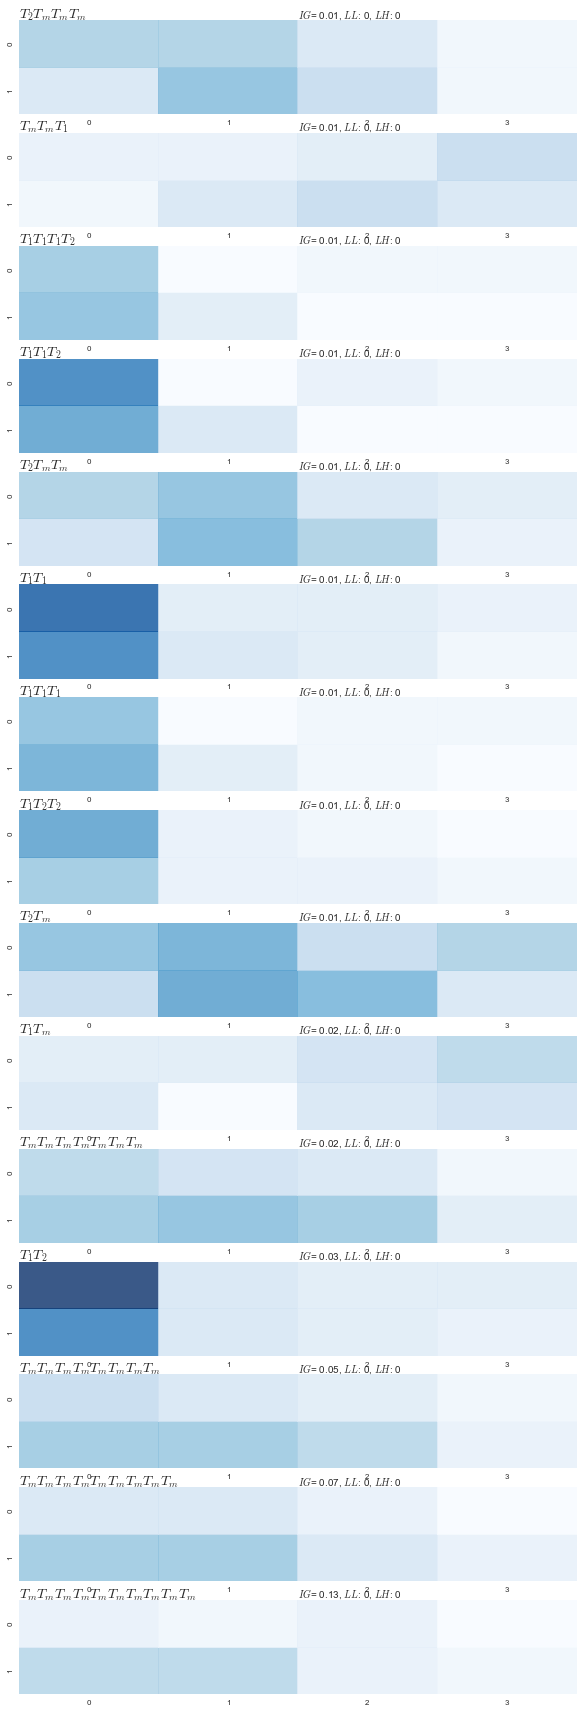

In [28]:
sns.set_style("darkgrid")
sns.set_context("paper")
all_seqs = zip(*tops)[0]
fig, axes = plt.subplots(len(tops),1)#, sharex=True, sharey=True)
maximum = int(max([np.amax(counts) for seq,counts in sequence_counts.iteritems() if seq in all_seqs]))
for i,(seq,ig) in enumerate(tops):
    ax = axes[i]
    data = sequence_counts[seq]
    ax = axes[i]
    hl,ll = 0,0
    seq = "$"+seq.replace('Ts','T_2').replace('Tb','T_1').replace('Tc','T_m')+"$"
    ax.text(0,2.05, seq, fontsize=14)
    ax.text(2.0,2.05, "$IG$= {0}, $LL$: {1}, $LH$: {2}".format(str(round(ig,2)),ll,hl), fontsize=10)
    heatmap = sns.heatmap(data, ax=ax, cmap=plt.cm.Blues,alpha=0.8, vmin=0, vmax=maximum, cbar=False,
                          annot=False) #, annot_kws={'fontweight':'bold'})
    fig.set_size_inches(10,30*len(test_seqs))
    ax.set_frame_on(False)
    i += 1

In [ ]:
# students = get_students(attribute='split pre',level='low')
# CUT_OFF = 0.35 #we keep only sequences used once by at least 10% of students
# shortest_seq_length = 2
# longest_seq_length = 10
# BINS = 4  #number of bins

# ### PARAMETERS
# attributes = [('split post t2','high','low')]
# family_categories = ["Family"]#,"Family_tool","Family_default"]

# parse_axis = {0:'time',1:'group',None:'time and group'}
# pdf = PdfPages('infogain_results_by_post2_testing_seqs.pdf')
# test_seqs = {}
# for attribute,level1,level2 in attributes:
#     for family_category in family_categories:
#         for axis in [1]:#,1,None]:
#             if axis == 1: B = 1
#             else: B = BINS
        
#             print "For attribute {0}, categories {1}".format(attribute,family_category)
#             pdf.savefig(add_text(attribute,family_category,CUT_OFF, shortest_seq_length, longest_seq_length,B))
#             sequence_counts = get_sequence_use_by_timebin(df,students,family_category,
#                                                           B,attribute,level1,level2,
#                                                           shortest_seq_length,longest_seq_length,CUT_OFF,remove_actions= ['C','P'])
#             test_seqs[axis] = sequence_counts
#             ylabels = [level1,level2]
#             tops = get_top_seqs(rank_sequences(sequence_counts,B,axis),15)
# #             print parse_axis[axis]
#             for seq,infogain in tops:
# #                 print seq, infogain
#                 title = '{0}: infogain {1} by {2}'.format(seq,round(infogain,3),parse_axis[axis])
#                 plot = plot_heat_map(sequence_counts[seq],title, ylabels)
#                 pdf.savefig( plot )
#                 plot.clf()
# pdf.close()